In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
import os
import zipfile
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image

# Define the paths to the zip files
all_dogs_zip_path = '../input/generative-dog-images/all-dogs.zip'
annotations_zip_path = '../input/generative-dog-images/Annotation.zip'
extract_all_dogs_path = './all-dogs/'
extract_annotations_path = './annotations/'

# Unzip all-dogs.zip
with zipfile.ZipFile(all_dogs_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_all_dogs_path)

# Unzip Annotation.zip
with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_annotations_path)

# Verify the contents
print("Contents of all-dogs directory:", os.listdir(extract_all_dogs_path))
print("Contents of annotations directory:", os.listdir(extract_annotations_path))


Contents of all-dogs directory: ['all-dogs']
Contents of annotations directory: ['Annotation', '__MACOSX']


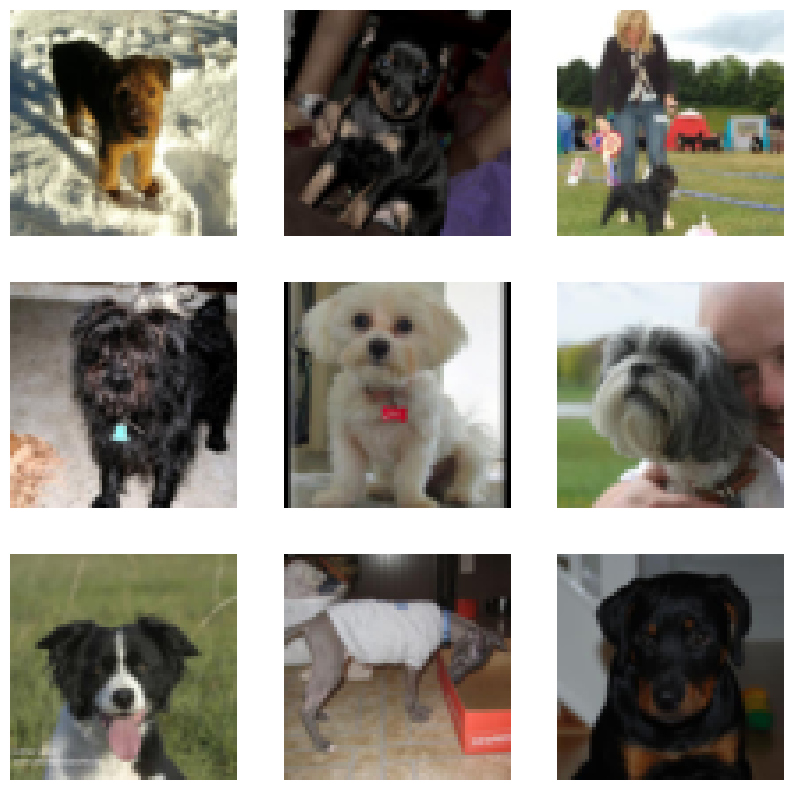

In [20]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
train_data = datasets.ImageFolder(extract_all_dogs_path, transform=transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)

# Visualize the loaded data
imgs, _ = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow((imgs[i] * 0.5 + 0.5))  # unnormalize
    plt.axis('off')
plt.show()


In [21]:
class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(nfeats * 8)
        self.conv2 = nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 8)
        self.conv3 = nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        self.conv4 = nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 2)
        self.conv5 = nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(nfeats)
        self.conv6 = nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2)
        x = torch.tanh(self.conv6(x))
        return x

class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        self.conv3 = nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        self.conv4 = nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(nfeats * 8)
        self.conv5 = nn.Conv2d(nfeats * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1, 1)


In [22]:
# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 100
netG = Generator(nz, 64, 3).to(device)
netD = Discriminator(3, 64).to(device)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [24]:
# Check if the output directory exists, if not, create it
output_dir = './output_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Training loop
epochs = 5
real_label = 1.
fake_label = 0.
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        # Update Discriminator with real data
        netD.zero_grad()
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Update Discriminator with fake data
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print training stats
        if i % 50 == 0:
            print(f'[{epoch}/{epochs}][{i}/{len(train_loader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    # Save generated images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    save_image(fake, f'./output_images/fake_samples_epoch_{epoch}.png', normalize=True)

# Save models
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')


[0/5][0/644] Loss_D: 2.0209 Loss_G: 3.0583 D(x): 0.8679 D(G(z)): 0.7722 / 0.0722
[0/5][50/644] Loss_D: 1.0010 Loss_G: 1.6932 D(x): 0.4947 D(G(z)): 0.1836 / 0.2077
[0/5][100/644] Loss_D: 1.0383 Loss_G: 2.6146 D(x): 0.6143 D(G(z)): 0.3390 / 0.1026
[0/5][150/644] Loss_D: 1.0455 Loss_G: 1.8243 D(x): 0.6135 D(G(z)): 0.3617 / 0.1858
[0/5][200/644] Loss_D: 1.3773 Loss_G: 1.9824 D(x): 0.6175 D(G(z)): 0.5210 / 0.1501
[0/5][250/644] Loss_D: 1.4503 Loss_G: 1.3381 D(x): 0.4732 D(G(z)): 0.4567 / 0.2775
[0/5][300/644] Loss_D: 0.9123 Loss_G: 2.4996 D(x): 0.7474 D(G(z)): 0.4203 / 0.0978
[0/5][350/644] Loss_D: 0.9192 Loss_G: 1.9948 D(x): 0.5615 D(G(z)): 0.2212 / 0.1675
[0/5][400/644] Loss_D: 0.7703 Loss_G: 2.6810 D(x): 0.6691 D(G(z)): 0.2537 / 0.0863
[0/5][450/644] Loss_D: 1.0840 Loss_G: 3.8143 D(x): 0.6980 D(G(z)): 0.4603 / 0.0256
[0/5][500/644] Loss_D: 1.0306 Loss_G: 1.6367 D(x): 0.4568 D(G(z)): 0.1569 / 0.2146
[0/5][550/644] Loss_D: 0.9735 Loss_G: 2.5418 D(x): 0.6148 D(G(z)): 0.2964 / 0.1003
[0/5][6

In [25]:
# Generate final set of images
os.makedirs('./output_images', exist_ok=True)
im_batch_size = 64
n_images = 10000
image_idx = 0

for i_batch in range(0, n_images, im_batch_size):
    noise = torch.randn(im_batch_size, nz, 1, 1, device=device)
    with torch.no_grad():
        gen_images = netG(noise).detach().cpu()
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], f'./output_images/image_{image_idx:05d}.png', normalize=True)
        image_idx += 1

# Zip the generated images
import shutil
shutil.make_archive('images', 'zip', './output_images')

'/kaggle/working/images.zip'